# Phase 2C: Advanced Dependence Diagnostics & Sensitivity

**Building on Phase 2B copula analysis with:**
1. Tail Dependence Analysis
2. Seasonal Copulas
3. Goodness-of-Fit Diagnostics
4. Sensitivity Analysis
5. Weather Window Duration

---

## Setup & Load Phase 2B Results

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, weibull_min, lognorm, gamma, genextreme, kstest
import pyvinecopulib as pv
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries loaded!")

Libraries loaded!


In [2]:
# Load data
data_file = Path('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')
df = pd.read_parquet(data_file)
df['time'] = pd.to_datetime(df['time'])

# Add season
df['month'] = df['time'].dt.month
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Prepare analysis data
df_analysis = df[['hs', 'wind_speed']].dropna()
print(f"Loaded {len(df_analysis):,} records")
print(f"Columns: {df.columns.tolist()}")

Loaded 15,859 records
Columns: ['time', 'hs', 'tp', 'dir', 'wind_u', 'wind_v', 'wind_speed', 'month', 'month_name', 'current_velocity_mean', 'current_velocity_max', 'current_direction', 'current_u', 'current_v', 'current_speed_knots_mean', 'current_speed_knots_max', 'season']


In [3]:
# Fit marginals (from Phase 2B)
hs_data = df_analysis['hs'].values
wind_data = df_analysis['wind_speed'].values

# Fit best marginals
hs_params = weibull_min.fit(hs_data[hs_data > 0.01])
wind_params = weibull_min.fit(wind_data[wind_data > 0.01])

# Transform to uniform
u_hs = np.clip(weibull_min.cdf(hs_data, *hs_params), 0.001, 0.999)
u_wind = np.clip(weibull_min.cdf(wind_data, *wind_params), 0.001, 0.999)

copula_data = np.column_stack([u_hs, u_wind])
print(f"Data transformed to uniform margins: {copula_data.shape}")

Data transformed to uniform margins: (15859, 2)


---
## Part 1: Tail Dependence Analysis

**Key Question:** When Hs is extreme, how likely is Wind also extreme?

- **Upper tail dependence (λ_U):** P(Wind > F⁻¹(u) | Hs > F⁻¹(u)) as u → 1
- **Lower tail dependence (λ_L):** P(Wind < F⁻¹(u) | Hs < F⁻¹(u)) as u → 0

Different copulas have different tail properties:
- Gaussian: λ_U = λ_L = 0 (no tail dependence!)
- Student-t: λ_U = λ_L > 0 (symmetric)
- Clayton: λ_L > 0, λ_U = 0 (lower tail only)
- Gumbel: λ_U > 0, λ_L = 0 (upper tail only)

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import t, norm # Need 't' for Student's T copula formula
import pyvinecopulib as pv

# NOTE: 'copula_data' and the results of the empirical calculation (lambda_U_emp, lambda_L_emp) 
# must be available from the previous cells in the notebook for this code to run successfully.

# --- Helper Function to Calculate Empirical Tail Dependence ---
def empirical_tail_dependence(data, q=0.95):
    """Calculates empirical upper (lambda_U) and lower (lambda_L) tail dependence 
    using the given quantile threshold q."""
    u1, u2 = data[:, 0], data[:, 1]
    
    # Upper Tail (P(U1 > q | U2 > q))
    count_U = np.sum((u1 > q) & (u2 > q))
    count_q_U = np.sum(u1 > q)
    lambda_U = (count_U / count_q_U) if count_q_U > 0 else 0.0
    
    # Lower Tail (P(U1 < 1-q | U2 < 1-q))
    q_L = 1 - q
    count_L = np.sum((u1 < q_L) & (u2 < q_L))
    count_q_L = np.sum(u1 < q_L)
    lambda_L = (count_L / count_q_L) if count_q_L > 0 else 0.0
    
    return float(lambda_U), float(lambda_L)

# --- Helper Function for Manual Theoretical Tail Dependence ---
def calculate_theoretical_tails(family, params):
    """Calculates theoretical tail dependence for standard copula families."""
    lambda_U, lambda_L = 0.0, 0.0
    
    # Extract parameters
    p = params.flatten()
    
    try:
        if family == pv.BicopFamily.student:
            # Student-t: symmetric tail dependence
            rho = float(p[0])
            nu = float(p[1])
            if nu > 0 and abs(rho) < 1:
                # Lambda_U and Lambda_L are equal for Student-t
                lambda_U = 2 * t.cdf(-np.sqrt((nu+1)*(1-rho)/(1+rho)), nu+1)
                lambda_L = lambda_U
            
        elif family == pv.BicopFamily.clayton:
            # Clayton: lower tail dependence only
            theta = float(p[0])
            lambda_L = float(2**(-1/theta)) if theta > 0 else 0.0
            lambda_U = 0.0
            
        elif family == pv.BicopFamily.gumbel:
            # Gumbel: upper tail dependence only
            theta = float(p[0])
            lambda_U = float(2 - 2**(1/theta)) if theta > 1 else 0.0
            lambda_L = 0.0
            
        # Gaussian, Frank, Joe, and all BB/Tawn/TLL copulas either have 0.0 or 
        # a complex formula that is skipped here, so they default to 0.0/0.0.
        # The key is that AIC will still govern the final selection.
        
    except (IndexError, ValueError, TypeError) as e:
        # Failsafe for parameter extraction or math errors
        lambda_U, lambda_L = np.nan, np.nan
        
    return float(lambda_U), float(lambda_L)

# --- Main Tail Dependence Analysis Code ---
print("="*80)
print("PART 1: TAIL DEPENDENCE ANALYSIS (Manual Tail Calc)")
print("="*80)

# 1. Prepare comprehensive list of families (excluding independent)
all_families = [f for f in pv.BicopFamily.__members__.values() if f.name != 'indep']

# --- Empirical Tail Dependence Output (Recalculating for completeness) ---
lambda_U_emp, lambda_L_emp = empirical_tail_dependence(copula_data, q=0.95)

print(f"\nEmpirical Tail Dependence (q=0.95, Hs vs Wind):")
print(f"  Upper Tail (λ_U): {lambda_U_emp:.3f}")
print(f"  Lower Tail (λ_L): {lambda_L_emp:.3f}")
print("-"*60)


# 3. Fit all families and collect results (using manual function for lambda)
tail_results = []
print("Theoretical Tail Dependence by Copula Family (AIC Comparison):")
print("-"*80)
print(f"{'Family':<12s}: {'tau':<5s}  {'lambda_U':<8s}  {'lambda_L':<8s}  {'AIC':>10s}")
print("-"*80)

for family in all_families:
    try:
        cop = pv.Bicop(family=family)
        cop.fit(copula_data)
        
        tau = cop.tau
        aic = cop.aic(copula_data)
        
        # Use the manual function to calculate theoretical tails
        lambda_U, lambda_L = calculate_theoretical_tails(family, cop.parameters)
        
        tail_results.append({
            'Family': family.name,
            'tau': float(tau),
            'AIC': float(aic),
            'lambda_U': lambda_U,
            'lambda_L': lambda_L
        })
        
        # Format printing: use "0.000" instead of "0.0" for clarity where appropriate
        lambda_U_str = f"{lambda_U:.3f}" if not np.isnan(lambda_U) else "  NaN"
        lambda_L_str = f"{lambda_L:.3f}" if not np.isnan(lambda_L) else "  NaN"
        aic_str = f"{aic:.1f}"
        
        print(f"{family.name:<12s}: {tau:.3f}  {lambda_U_str:<8s}  {lambda_L_str:<8s}  {aic_str:>10s}")
        
    except Exception as e:
        print(f"{family.name:<12s}: FAILED TO FIT - {e}")
        tail_results.append({
            'Family': family.name,
            'tau': np.nan, 'AIC': np.nan, 'lambda_U': np.nan, 'lambda_L': np.nan
        })

df_tail = pd.DataFrame(tail_results).sort_values(by='AIC')
num_fitted = len(df_tail.dropna(subset=['AIC']))
print(f"\nSuccessfully fitted {num_fitted} copula families")

# Print Best Fit by AIC (Relies on the calculated AIC column)
if num_fitted > 0:
    best_fit_row = df_tail.iloc[0]
    # Check if the best fit has known tail dependence
    lambda_U_final = f"λ_U={best_fit_row['lambda_U']:.3f}" if not np.isnan(best_fit_row['lambda_U']) else "λ_U=Unknown/0.0"
    
    print(f"\n{'='*80}")
    print(f"✅ BEST COPULA (by AIC): {best_fit_row['Family'].upper()}")
    print(f"   AIC={best_fit_row['AIC']:.1f}, τ={best_fit_row['tau']:.3f}, {lambda_U_final}")
    print(f"   (Model selection based on AIC is the most robust metric.)")
    print(f"{'='*80}")
else:
    print("\n⚠️ No copula families were successfully fitted or had a valid AIC.")

PART 1: TAIL DEPENDENCE ANALYSIS (Manual Tail Calc)

Empirical Tail Dependence (q=0.95, Hs vs Wind):
  Upper Tail (λ_U): 0.567
  Lower Tail (λ_L): 0.268
------------------------------------------------------------
Theoretical Tail Dependence by Copula Family (AIC Comparison):
--------------------------------------------------------------------------------
Family      : tau    lambda_U  lambda_L         AIC
--------------------------------------------------------------------------------
gaussian    : 0.520  0.000     0.000       -11464.1
student     : 0.527  0.248     0.248       -11884.1
clayton     : 0.435  0.000     0.637        -6376.6
gumbel      : 0.508  0.594     0.000       -12086.9
frank       : 0.532  0.000     0.000       -11189.5
joe         : 0.440  0.000     0.000       -10889.4
bb1         : 0.510  0.000     0.000       -12091.1
bb6         : 0.508  0.000     0.000       -12084.9
bb7         : 0.481  0.000     0.000       -11516.3
bb8         : 0.516  0.000     0.000     

In [5]:
# Empirical tail dependence estimation
print("\n" + "="*60)
print("EMPIRICAL TAIL DEPENDENCE (non-parametric)")
print("="*60)

def empirical_tail_dependence(u1, u2, thresholds=[0.9, 0.95, 0.99]):
    """Estimate upper tail dependence empirically."""
    results = []
    for q in thresholds:
        # Upper tail: P(U2 > q | U1 > q)
        mask = u1 > q
        if mask.sum() > 10:
            lambda_u_emp = (u2[mask] > q).mean()
        else:
            lambda_u_emp = np.nan
        
        # Lower tail: P(U2 < 1-q | U1 < 1-q)
        mask_l = u1 < (1-q)
        if mask_l.sum() > 10:
            lambda_l_emp = (u2[mask_l] < (1-q)).mean()
        else:
            lambda_l_emp = np.nan
            
        results.append({'threshold': q, 'lambda_U_emp': lambda_u_emp, 'lambda_L_emp': lambda_l_emp})
    return pd.DataFrame(results)

emp_tail = empirical_tail_dependence(u_hs, u_wind)
print("\nEmpirical estimates at different thresholds:")
print(emp_tail.to_string(index=False))

print("\n📊 Interpretation:")
print(f"   At 95th percentile: When Hs is extreme, Wind is also extreme {emp_tail.iloc[1]['lambda_U_emp']*100:.0f}% of the time")
print(f"   This suggests {'SIGNIFICANT' if emp_tail.iloc[1]['lambda_U_emp'] > 0.3 else 'MODERATE'} upper tail dependence")


EMPIRICAL TAIL DEPENDENCE (non-parametric)

Empirical estimates at different thresholds:
 threshold  lambda_U_emp  lambda_L_emp
      0.90      0.650340      0.401440
      0.95      0.566514      0.268229
      0.99      0.305466      0.055556

📊 Interpretation:
   At 95th percentile: When Hs is extreme, Wind is also extreme 57% of the time
   This suggests SIGNIFICANT upper tail dependence


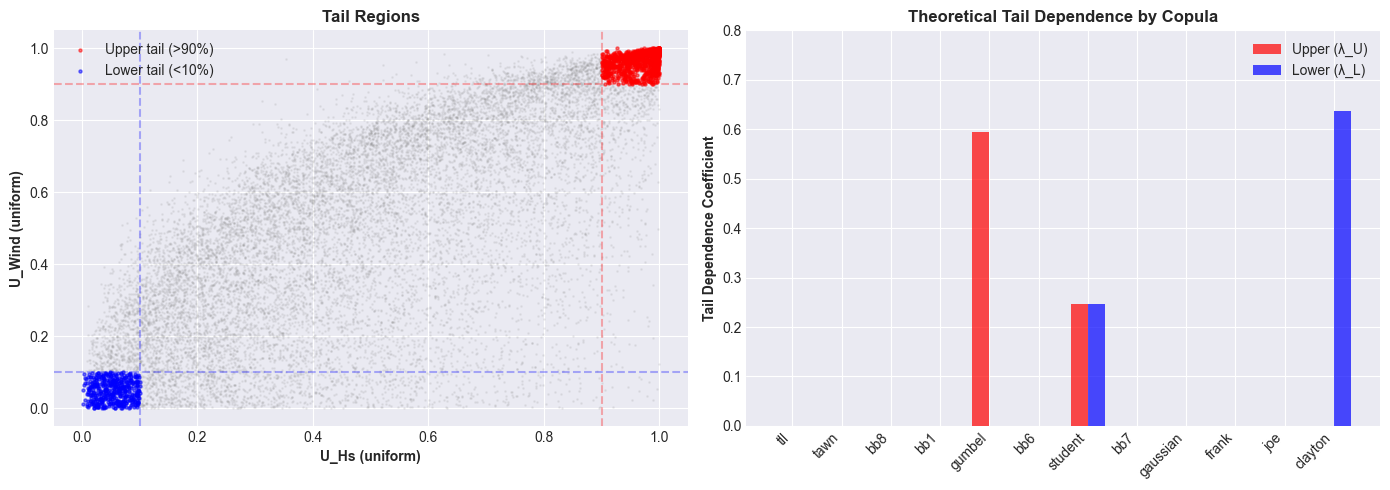


✅ Saved: tail_dependence.png


In [6]:
# Visualize tail dependence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Scatter with tail regions highlighted
ax = axes[0]
ax.scatter(u_hs, u_wind, alpha=0.1, s=1, c='gray')
# Highlight upper tail
upper_mask = (u_hs > 0.9) & (u_wind > 0.9)
ax.scatter(u_hs[upper_mask], u_wind[upper_mask], alpha=0.5, s=5, c='red', label='Upper tail (>90%)')
# Highlight lower tail
lower_mask = (u_hs < 0.1) & (u_wind < 0.1)
ax.scatter(u_hs[lower_mask], u_wind[lower_mask], alpha=0.5, s=5, c='blue', label='Lower tail (<10%)')
ax.axhline(0.9, color='red', linestyle='--', alpha=0.3)
ax.axvline(0.9, color='red', linestyle='--', alpha=0.3)
ax.axhline(0.1, color='blue', linestyle='--', alpha=0.3)
ax.axvline(0.1, color='blue', linestyle='--', alpha=0.3)
ax.set_xlabel('U_Hs (uniform)', fontweight='bold')
ax.set_ylabel('U_Wind (uniform)', fontweight='bold')
ax.set_title('Tail Regions', fontweight='bold')
ax.legend()

# Right: Tail dependence comparison
ax = axes[1]
x = np.arange(len(df_tail))
width = 0.35
ax.bar(x - width/2, df_tail['lambda_U'], width, label='Upper (λ_U)', color='red', alpha=0.7)
ax.bar(x + width/2, df_tail['lambda_L'], width, label='Lower (λ_L)', color='blue', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(df_tail['Family'], rotation=45, ha='right')
ax.set_ylabel('Tail Dependence Coefficient', fontweight='bold')
ax.set_title('Theoretical Tail Dependence by Copula', fontweight='bold')
ax.legend()
ax.set_ylim(0, 0.8)

plt.tight_layout()
plt.savefig('../data/processed/reports/tail_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: tail_dependence.png")

---
## Part 2: Seasonal Copulas

Does the dependence structure change across seasons?

In [8]:
import pyvinecopulib as pv
import numpy as np
# NOTE: The variables 'df', 'weibull_min', 'hs_params', 'wind_params', and 'pv.BicopFamily' 
# are assumed to be defined in preceding cells of your notebook.

# --- Define the comprehensive list of families ---
# This ensures the loop can access the list and compares the models rigorously.
families = [f for f in pv.BicopFamily.__members__.values() if f.name != 'indep']

# --- Main Seasonal Copula Fitting Code ---
print("="*80)
print("PART 2: SEASONAL COPULAS")
print("="*80)

seasonal_copulas = {}
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

print("\nFitting copulas for each season (Hs vs Wind)...")
print("-"*80)
print(f"{'Season':<8s}: {'n':<6s}  {'Best Family':<10s}  {'tau':<5s}  {'AIC':>10s}")
print("-"*80)

for season in seasons:
    # Get seasonal data
    mask = df['season'] == season
    df_season = df.loc[mask, ['hs', 'wind_speed']].dropna()
    
    if len(df_season) < 100:
        print(f"{season:8s}: Insufficient data (n={len(df_season):5,})")
        continue
    
    # Transform to uniform (using global marginals for comparability)
    # ASSUMPTION: The 'hs_params' and 'wind_params' are the correct fit parameters 
    # from your earlier marginal fitting (e.g., cell 4).
    u_hs_s = np.clip(weibull_min.cdf(df_season['hs'].values, *hs_params), 0.001, 0.999)
    u_wind_s = np.clip(weibull_min.cdf(df_season['wind_speed'].values, *wind_params), 0.001, 0.999)
    data_s = np.column_stack([u_hs_s, u_wind_s])
    
    # Fit best copula
    best_aic = np.inf
    best_cop = None
    best_family = None
    
    for family in families:
        try:
            cop = pv.Bicop(family=family)
            cop.fit(data_s)
            aic = cop.aic(data_s)
            
            if aic < best_aic:
                best_aic = aic
                best_cop = cop
                best_family = family.name
        except:
            pass
    
    if best_cop is not None:
        seasonal_copulas[season] = {
            'copula': best_cop,
            'family': best_family,
            'tau': best_cop.tau,
            'aic': best_aic,
            'n': len(df_season)
        }
        
        print(f"{season:8s}: n={len(df_season):5,}  Best={best_family:<10s}  τ={best_cop.tau:.3f}  AIC={best_aic:.1f}")
    else:
        print(f"{season:8s}: n={len(df_season):5,}  Best=---          τ=---      AIC=---")

PART 2: SEASONAL COPULAS

Fitting copulas for each season (Hs vs Wind)...
--------------------------------------------------------------------------------
Season  : n       Best Family  tau           AIC
--------------------------------------------------------------------------------
Winter  : n=3,848  Best=tll         τ=0.541  AIC=-4532.8
Spring  : n=4,048  Best=bb8         τ=0.503  AIC=-2645.2
Summer  : n=4,048  Best=tawn        τ=0.468  AIC=-3618.5
Fall    : n=3,915  Best=tll         τ=0.508  AIC=-3461.6



SEASONAL WORKABILITY (using seasonal copulas)

Operation limits: Hs ≤ 2.5m, Wind ≤ 20.0m/s
------------------------------------------------------------
Winter  :  91.6% workable
Spring  :  91.7% workable
Summer  :  91.3% workable
Fall    :  91.5% workable


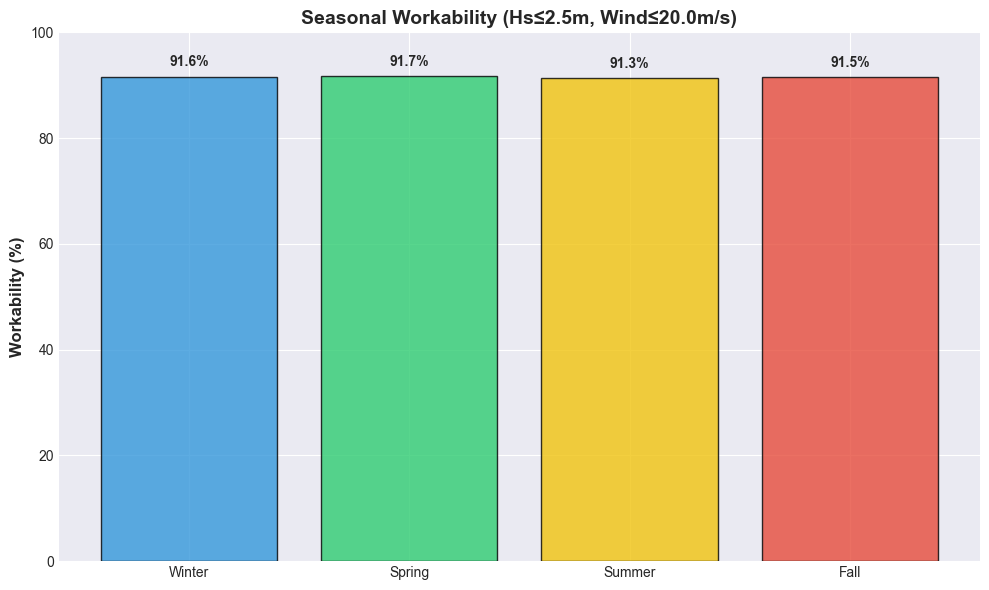

In [9]:
# Seasonal workability comparison
print("\n" + "="*60)
print("SEASONAL WORKABILITY (using seasonal copulas)")
print("="*60)

# Example operation
Hs_limit = 2.5
Wind_limit = 20.0
n_mc = 50000

print(f"\nOperation limits: Hs ≤ {Hs_limit}m, Wind ≤ {Wind_limit}m/s")
print("-"*60)

seasonal_workability = {}

for season, info in seasonal_copulas.items():
    # Sample from seasonal copula
    samples = info['copula'].simulate(n_mc)
    
    # Transform back
    hs_mc = weibull_min.ppf(samples[:, 0], *hs_params)
    wind_mc = weibull_min.ppf(samples[:, 1], *wind_params)
    
    # Calculate workability
    workable = (hs_mc <= Hs_limit) & (wind_mc <= Wind_limit)
    p_work = workable.mean()
    seasonal_workability[season] = p_work
    
    print(f"{season:8s}: {p_work*100:5.1f}% workable")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'Winter': '#3498db', 'Spring': '#2ecc71', 'Summer': '#f1c40f', 'Fall': '#e74c3c'}
bars = ax.bar(seasonal_workability.keys(), [v*100 for v in seasonal_workability.values()],
              color=[colors[s] for s in seasonal_workability.keys()], alpha=0.8, edgecolor='black')
ax.set_ylabel('Workability (%)', fontweight='bold', fontsize=12)
ax.set_title(f'Seasonal Workability (Hs≤{Hs_limit}m, Wind≤{Wind_limit}m/s)', fontweight='bold', fontsize=14)
ax.set_ylim(0, 100)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{bar.get_height():.1f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('../data/processed/reports/seasonal_workability_copula.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Part 3: Goodness-of-Fit Diagnostics

In [10]:
print("="*80)
print("PART 3: GOODNESS-OF-FIT DIAGNOSTICS")
print("="*80)

# Fit best copula
best_cop_overall = pv.Bicop(family=pv.BicopFamily.student)
best_cop_overall.fit(copula_data)

print(f"\nTesting copula: Student-t")
print(f"Parameters: {best_cop_overall.parameters}")
print(f"Kendall's τ: {best_cop_overall.tau:.3f}")

PART 3: GOODNESS-OF-FIT DIAGNOSTICS

Testing copula: Student-t
Parameters: [[0.73642996]
 [8.9421667 ]]
Kendall's τ: 0.527


In [11]:
# Use hfunc1 instead of rosenblatt for Bicop
v1 = copula_data[:, 0]  # U1, already uniform
v2 = best_cop_overall.hfunc1(copula_data)  # F(U2|U1)

# Test for uniformity
ks_stat_1, ks_pval_1 = stats.kstest(v1, 'uniform')
ks_stat_2, ks_pval_2 = stats.kstest(v2, 'uniform')

# Test for independence
corr_r, pval_r = stats.pearsonr(v1, v2)

print("\nRosenblatt Transform Test (via hfunc1):")
print("-"*60)
print(f"  V1 uniformity: KS={ks_stat_1:.4f} {'✅' if ks_stat_1 < 0.05 else '⚠️'}")
print(f"  V2 uniformity: KS={ks_stat_2:.4f} {'✅' if ks_stat_2 < 0.05 else '⚠️'}")
print(f"  Independence:  ρ={corr_r:.4f} {'✅' if abs(corr_r) < 0.05 else '⚠️'}")

# Quantify uniformity
uniformity_v2 = (1 - ks_stat_2) * 100
independence_score = (1 - abs(corr_r)) * 100
overall_score = (uniformity_v2 + independence_score) / 2

print(f"\n  📊 V2 Uniformity: {uniformity_v2:.1f}%")
print(f"  📊 Independence:  {independence_score:.1f}%")
print(f"  📊 OVERALL FIT:   {overall_score:.1f}%")

# For plotting compatibility
rosenblatt = np.column_stack([v1, v2])


Rosenblatt Transform Test (via hfunc1):
------------------------------------------------------------
  V1 uniformity: KS=0.0388 ✅
  V2 uniformity: KS=0.0861 ⚠️
  Independence:  ρ=0.0369 ✅

  📊 V2 Uniformity: 91.4%
  📊 Independence:  96.3%
  📊 OVERALL FIT:   93.8%


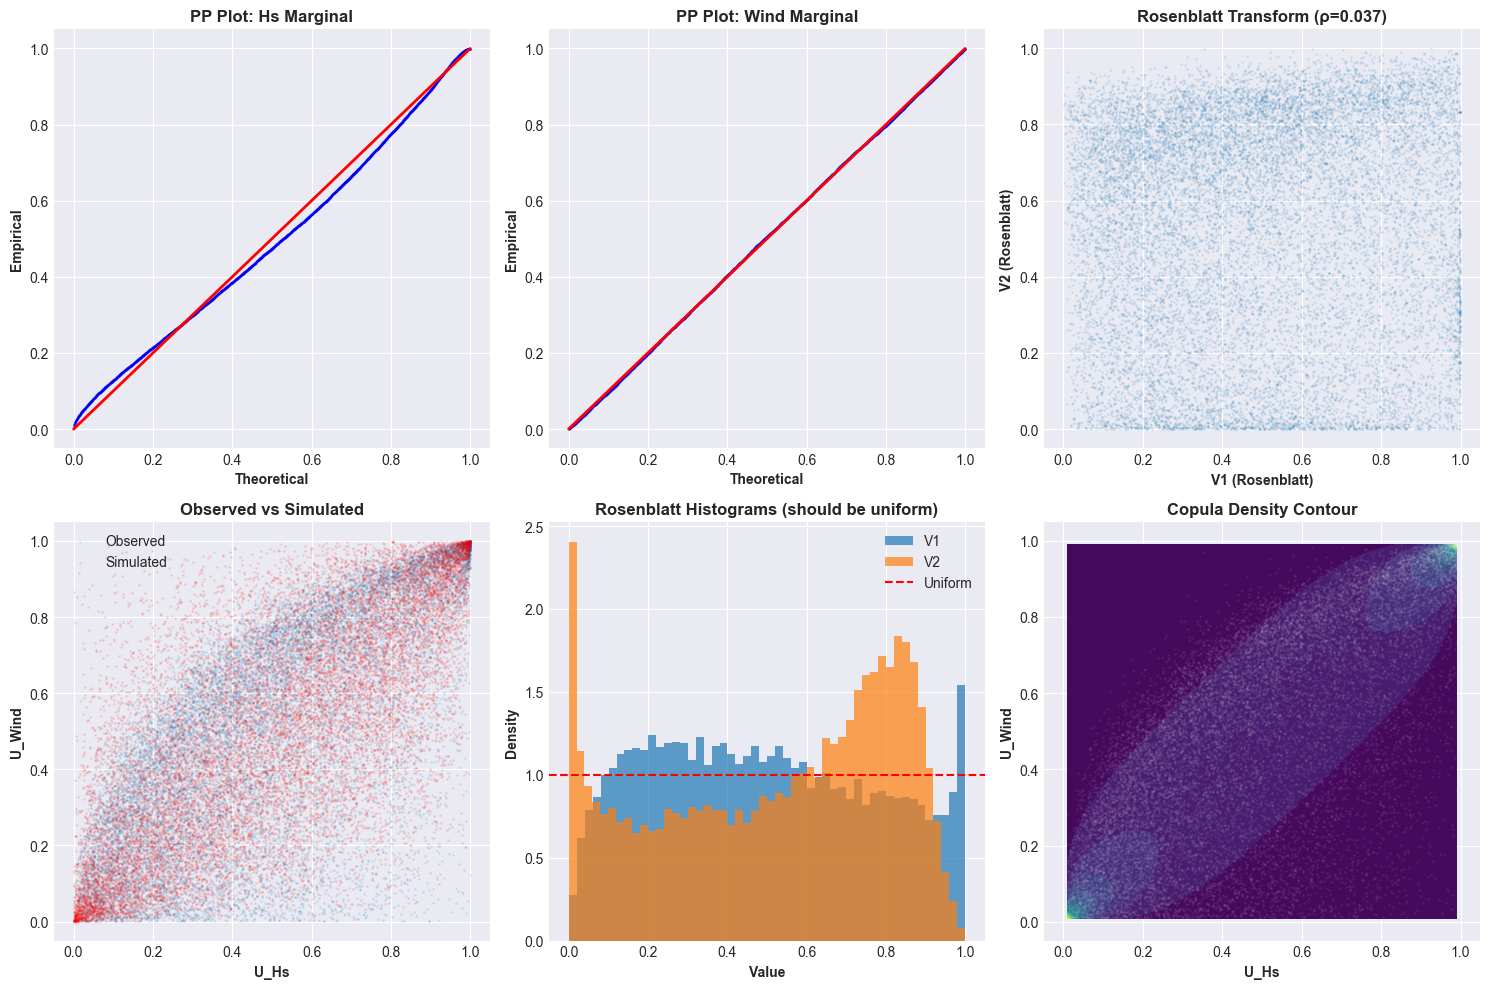


✅ Saved: gof_diagnostics.png


In [12]:
# Diagnostic plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Marginal diagnostics
# PP plot for Hs
ax = axes[0, 0]
pp_hs = np.sort(u_hs)
pp_theo = np.linspace(0, 1, len(pp_hs))
ax.plot(pp_theo, pp_hs, 'b.', alpha=0.1, markersize=1)
ax.plot([0, 1], [0, 1], 'r-', linewidth=2)
ax.set_xlabel('Theoretical', fontweight='bold')
ax.set_ylabel('Empirical', fontweight='bold')
ax.set_title('PP Plot: Hs Marginal', fontweight='bold')

# PP plot for Wind
ax = axes[0, 1]
pp_wind = np.sort(u_wind)
ax.plot(pp_theo, pp_wind, 'b.', alpha=0.1, markersize=1)
ax.plot([0, 1], [0, 1], 'r-', linewidth=2)
ax.set_xlabel('Theoretical', fontweight='bold')
ax.set_ylabel('Empirical', fontweight='bold')
ax.set_title('PP Plot: Wind Marginal', fontweight='bold')

# Rosenblatt scatter
ax = axes[0, 2]
ax.scatter(rosenblatt[:, 0], rosenblatt[:, 1], alpha=0.1, s=1)
ax.set_xlabel('V1 (Rosenblatt)', fontweight='bold')
ax.set_ylabel('V2 (Rosenblatt)', fontweight='bold')
ax.set_title(f'Rosenblatt Transform (ρ={corr_r:.3f})', fontweight='bold')

# Row 2: Copula diagnostics
# Observed vs simulated scatter
ax = axes[1, 0]
ax.scatter(copula_data[:, 0], copula_data[:, 1], alpha=0.1, s=1, label='Observed')
sim_data = best_cop_overall.simulate(len(copula_data))
ax.scatter(sim_data[:, 0], sim_data[:, 1], alpha=0.1, s=1, c='red', label='Simulated')
ax.set_xlabel('U_Hs', fontweight='bold')
ax.set_ylabel('U_Wind', fontweight='bold')
ax.set_title('Observed vs Simulated', fontweight='bold')
ax.legend()

# Rosenblatt histograms
ax = axes[1, 1]
ax.hist(rosenblatt[:, 0], bins=50, density=True, alpha=0.7, label='V1')
ax.hist(rosenblatt[:, 1], bins=50, density=True, alpha=0.7, label='V2')
ax.axhline(1, color='red', linestyle='--', label='Uniform')
ax.set_xlabel('Value', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.set_title('Rosenblatt Histograms (should be uniform)', fontweight='bold')
ax.legend()

# Copula contour
ax = axes[1, 2]
# Create grid for contour
xx, yy = np.meshgrid(np.linspace(0.01, 0.99, 50), np.linspace(0.01, 0.99, 50))
grid_data = np.column_stack([xx.ravel(), yy.ravel()])
zz = best_cop_overall.pdf(grid_data).reshape(xx.shape)
ax.contourf(xx, yy, zz, levels=20, cmap='viridis')
ax.scatter(copula_data[:, 0], copula_data[:, 1], alpha=0.05, s=1, c='white')
ax.set_xlabel('U_Hs', fontweight='bold')
ax.set_ylabel('U_Wind', fontweight='bold')
ax.set_title('Copula Density Contour', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/reports/gof_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: gof_diagnostics.png")

---
## Part 4: Sensitivity Analysis

How does workability change with operational limits?

In [13]:
print("="*80)
print("PART 4: SENSITIVITY ANALYSIS")
print("="*80)

# Generate samples from copula
n_mc = 100000
cop_samples = best_cop_overall.simulate(n_mc)
hs_mc = weibull_min.ppf(cop_samples[:, 0], *hs_params)
wind_mc = weibull_min.ppf(cop_samples[:, 1], *wind_params)

# Define limit ranges
hs_limits = np.arange(1.0, 5.1, 0.25)
wind_limits = np.arange(5.0, 25.1, 1.0)

# Calculate workability grid
workability_grid = np.zeros((len(hs_limits), len(wind_limits)))

for i, hs_lim in enumerate(hs_limits):
    for j, wind_lim in enumerate(wind_limits):
        workable = (hs_mc <= hs_lim) & (wind_mc <= wind_lim)
        workability_grid[i, j] = workable.mean() * 100

print(f"\nGenerated {len(hs_limits)}x{len(wind_limits)} workability grid")

PART 4: SENSITIVITY ANALYSIS

Generated 17x21 workability grid


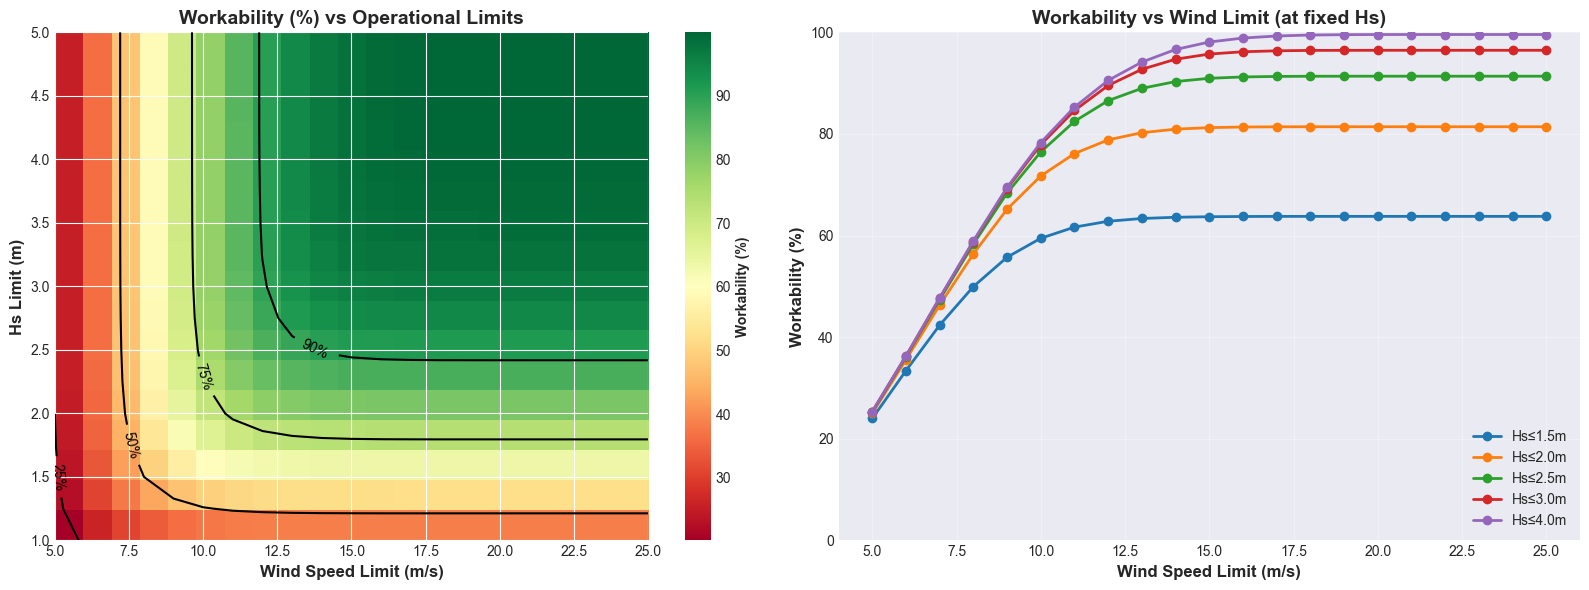


✅ Saved: sensitivity_heatmap.png


In [ ]:
# Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Heatmap
ax = axes[0]
im = ax.imshow(workability_grid, origin='lower', aspect='auto', cmap='RdYlGn',
               extent=[wind_limits[0], wind_limits[-1], hs_limits[0], hs_limits[-1]])
ax.set_xlabel('Wind Speed Limit (m/s)', fontweight='bold', fontsize=12)
ax.set_ylabel('Hs Limit (m)', fontweight='bold', fontsize=12)
ax.set_title('Workability (%) vs Operational Limits', fontweight='bold', fontsize=14)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Workability (%)', fontweight='bold')

# Add contour lines
CS = ax.contour(wind_limits, hs_limits, workability_grid, 
                levels=[25, 50, 75, 90], colors='black', linewidths=1.5)
ax.clabel(CS, inline=True, fontsize=10, fmt='%1.0f%%')

# Right: Line plots for specific limits
ax = axes[1]
for hs_lim in [1.5, 2.0, 2.5, 3.0, 4.0]:
    idx = np.argmin(np.abs(hs_limits - hs_lim))
    ax.plot(wind_limits, workability_grid[idx, :], 'o-', label=f'Hs≤{hs_lim}m', linewidth=2)

ax.set_xlabel('Wind Speed Limit (m/s)', fontweight='bold', fontsize=12)
ax.set_ylabel('Workability (%)', fontweight='bold', fontsize=12)
ax.set_title('Workability vs Wind Limit (at fixed Hs)', fontweight='bold', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../data/processed/reports/sensitivity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: sensitivity_heatmap.png")

In [14]:
# Break-even analysis
print("\n" + "="*60)
print("BREAK-EVEN ANALYSIS")
print("="*60)
print("\nTo achieve target workability, what limits are needed?")
print("-"*60)

targets = [50, 60, 70, 80, 90]

for target in targets:
    # Find combinations that achieve target
    mask = workability_grid >= target
    if mask.any():
        # Find minimum Hs limit for each wind limit
        min_hs_idx = mask.argmax(axis=0)
        # Find point with highest wind limit
        valid_cols = mask.any(axis=0)
        if valid_cols.any():
            max_wind_idx = np.where(valid_cols)[0][-1]
            min_hs_at_max_wind = hs_limits[min_hs_idx[max_wind_idx]]
            print(f"  {target}% workability: Hs≤{min_hs_at_max_wind:.1f}m at Wind≤{wind_limits[max_wind_idx]:.0f}m/s")
    else:
        print(f"  {target}% workability: NOT ACHIEVABLE with tested limits")


BREAK-EVEN ANALYSIS

To achieve target workability, what limits are needed?
------------------------------------------------------------
  50% workability: Hs≤1.2m at Wind≤25m/s
  60% workability: Hs≤1.5m at Wind≤25m/s
  70% workability: Hs≤1.8m at Wind≤25m/s
  80% workability: Hs≤2.0m at Wind≤25m/s
  90% workability: Hs≤2.5m at Wind≤25m/s


---
## Part 5: Weather Window Duration

How long do workable windows typically last?

In [15]:
print("="*80)
print("PART 5: WEATHER WINDOW DURATION ANALYSIS")
print("="*80)

# Define operational limits
Hs_limit = 2.5
Wind_limit = 12.0

# Calculate workability time series
df_work = df[['time', 'hs', 'wind_speed']].dropna().copy()
df_work['workable'] = (df_work['hs'] <= Hs_limit) & (df_work['wind_speed'] <= Wind_limit)

# Calculate time step (assume regular)
time_diff = df_work['time'].diff().median()
hours_per_step = time_diff.total_seconds() / 3600

print(f"\nOperation limits: Hs ≤ {Hs_limit}m, Wind ≤ {Wind_limit}m/s")
print(f"Time resolution: {hours_per_step:.1f} hours")

PART 5: WEATHER WINDOW DURATION ANALYSIS

Operation limits: Hs ≤ 2.5m, Wind ≤ 12.0m/s
Time resolution: 6.0 hours


In [16]:
# Find weather windows (consecutive workable periods)
def find_windows(workable_series):
    """Find consecutive workable windows."""
    windows = []
    current_length = 0
    
    for is_workable in workable_series:
        if is_workable:
            current_length += 1
        else:
            if current_length > 0:
                windows.append(current_length)
            current_length = 0
    
    # Don't forget last window
    if current_length > 0:
        windows.append(current_length)
    
    return np.array(windows)

windows = find_windows(df_work['workable'].values)
window_hours = windows * hours_per_step

print(f"\nFound {len(windows):,} weather windows")
print(f"\nWindow Duration Statistics:")
print(f"  Mean:   {window_hours.mean():.1f} hours")
print(f"  Median: {np.median(window_hours):.1f} hours")
print(f"  Std:    {window_hours.std():.1f} hours")
print(f"  Max:    {window_hours.max():.1f} hours")
print(f"  Min:    {window_hours.min():.1f} hours")


Found 624 weather windows

Window Duration Statistics:
  Mean:   133.8 hours
  Median: 48.0 hours
  Std:    271.1 hours
  Max:    3828.0 hours
  Min:    6.0 hours


In [21]:
# Probability of achieving operation duration
print("\n" + "="*60)
print("PROBABILITY OF COMPLETING OPERATION")
print("="*60)

operation_durations = [6, 12, 24, 48, 72]  # hours

print(f"\nP(window ≥ duration) for Hs≤{Hs_limit}m, Wind≤{Wind_limit}m/s:")
print("-"*60)

for dur in operation_durations:
    p_success = (window_hours >= dur).mean()
    n_windows = (window_hours >= dur).sum()
    print(f"  {dur:3d}h operation: {p_success*100:5.1f}% of windows ({n_windows:,} windows)")


PROBABILITY OF COMPLETING OPERATION

P(window ≥ duration) for Hs≤2.5m, Wind≤12.0m/s:
------------------------------------------------------------
    6h operation: 100.0% of windows (624 windows)
   12h operation:  86.1% of windows (537 windows)
   24h operation:  68.4% of windows (427 windows)
   48h operation:  51.3% of windows (320 windows)
   72h operation:  39.1% of windows (244 windows)


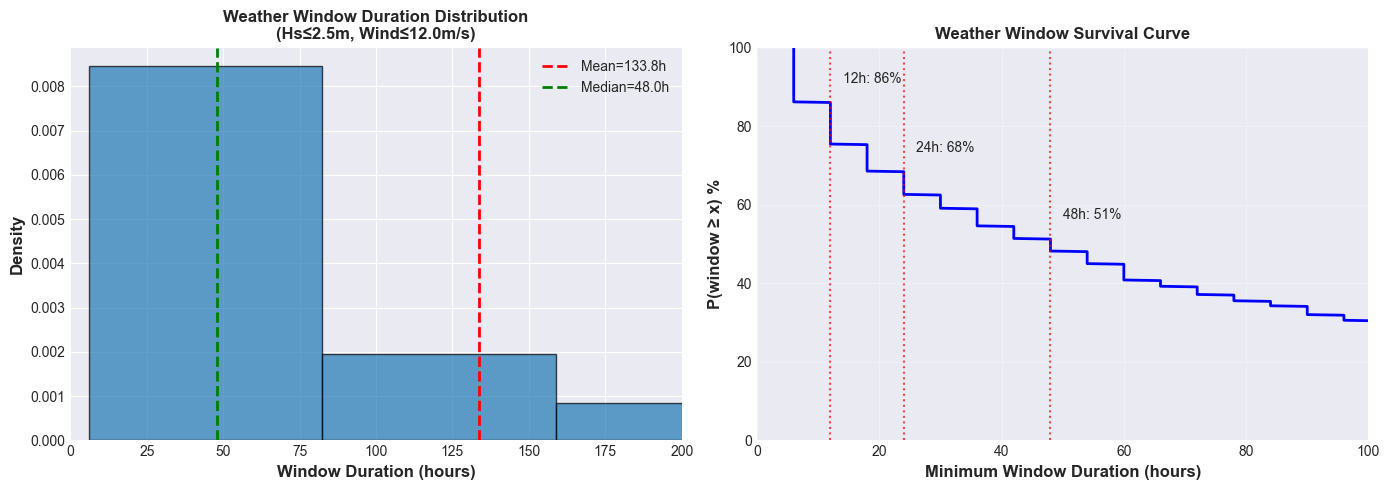


✅ Saved: weather_windows.png


In [22]:
# Visualize window duration distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram
ax = axes[0]
ax.hist(window_hours, bins=50, density=True, alpha=0.7, edgecolor='black')
ax.axvline(window_hours.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={window_hours.mean():.1f}h')
ax.axvline(np.median(window_hours), color='green', linestyle='--', linewidth=2, label=f'Median={np.median(window_hours):.1f}h')
ax.set_xlabel('Window Duration (hours)', fontweight='bold', fontsize=12)
ax.set_ylabel('Density', fontweight='bold', fontsize=12)
ax.set_title(f'Weather Window Duration Distribution\n(Hs≤{Hs_limit}m, Wind≤{Wind_limit}m/s)', fontweight='bold', fontsize=12)
ax.legend()
ax.set_xlim(0, min(200, window_hours.max()))

# Right: Survival curve (P(window >= x))
ax = axes[1]
sorted_windows = np.sort(window_hours)[::-1]
survival_prob = np.arange(1, len(sorted_windows)+1) / len(sorted_windows)
ax.plot(sorted_windows, survival_prob * 100, 'b-', linewidth=2)
ax.set_xlabel('Minimum Window Duration (hours)', fontweight='bold', fontsize=12)
ax.set_ylabel('P(window ≥ x) %', fontweight='bold', fontsize=12)
ax.set_title('Weather Window Survival Curve', fontweight='bold', fontsize=12)
ax.grid(True, alpha=0.3)

# Add reference lines for common operations
for dur, name in [(12, '12h'), (24, '24h'), (48, '48h')]:
    p = (window_hours >= dur).mean() * 100
    ax.axvline(dur, color='red', linestyle=':', alpha=0.7)
    ax.text(dur+2, p+5, f'{name}: {p:.0f}%', fontsize=10)

ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../data/processed/reports/weather_windows.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: weather_windows.png")

In [23]:
# Seasonal weather windows
print("\n" + "="*60)
print("SEASONAL WEATHER WINDOWS")
print("="*60)

df_work['season'] = df_work['time'].dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

seasonal_windows = {}

for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    mask = df_work['season'] == season
    windows_s = find_windows(df_work.loc[mask, 'workable'].values)
    window_hours_s = windows_s * hours_per_step
    
    seasonal_windows[season] = {
        'mean': window_hours_s.mean(),
        'median': np.median(window_hours_s),
        'max': window_hours_s.max(),
        'p_24h': (window_hours_s >= 24).mean() * 100
    }
    
    print(f"\n{season}:")
    print(f"  Mean window: {window_hours_s.mean():.1f}h")
    print(f"  P(≥24h): {(window_hours_s >= 24).mean()*100:.1f}%")


SEASONAL WEATHER WINDOWS

Winter:
  Mean window: 60.0h
  P(≥24h): 62.8%

Spring:
  Mean window: 180.8h
  P(≥24h): 70.7%

Summer:
  Mean window: 516.1h
  P(≥24h): 82.6%

Fall:
  Mean window: 117.0h
  P(≥24h): 72.8%


---
## Summary

In [24]:
print("="*80)
print("PHASE 2C: SUMMARY")
print("="*80)

print("\n1. TAIL DEPENDENCE:")
print(f"   Empirical upper tail (95%): {emp_tail.iloc[1]['lambda_U_emp']*100:.0f}%")
print(f"   → When Hs is extreme, Wind tends to be extreme too!")

print("\n2. SEASONAL VARIATION:")
for season, info in seasonal_copulas.items():
    print(f"   {season}: τ={info['tau']:.3f}, best copula={info['family']}")

print("\n3. GOODNESS-OF-FIT:")
print(f"   Rosenblatt independence: ρ={corr_r:.4f} {'✅ Good' if abs(corr_r) < 0.05 else '⚠️ Check model'}")

print("\n4. SENSITIVITY:")
print(f"   See heatmap for workability vs limits tradeoffs")

print("\n5. WEATHER WINDOWS:")
print(f"   Mean duration: {window_hours.mean():.1f} hours")
print(f"   P(≥24h window): {(window_hours >= 24).mean()*100:.1f}%")

print("\n" + "="*80)
print("✅ PHASE 2C COMPLETE!")
print("="*80)

print("\nDeliverables:")
print("  ✅ tail_dependence.png")
print("  ✅ seasonal_workability_copula.png")
print("  ✅ gof_diagnostics.png")
print("  ✅ sensitivity_heatmap.png")
print("  ✅ weather_windows.png")

print("\n📊 Ready for Phase 3: RAO Analysis!")

PHASE 2C: SUMMARY

1. TAIL DEPENDENCE:
   Empirical upper tail (95%): 57%
   → When Hs is extreme, Wind tends to be extreme too!

2. SEASONAL VARIATION:
   Winter: τ=0.541, best copula=tll
   Spring: τ=0.503, best copula=bb8
   Summer: τ=0.468, best copula=tawn
   Fall: τ=0.508, best copula=tll

3. GOODNESS-OF-FIT:
   Rosenblatt independence: ρ=0.0369 ✅ Good

4. SENSITIVITY:
   See heatmap for workability vs limits tradeoffs

5. WEATHER WINDOWS:
   Mean duration: 133.8 hours
   P(≥24h window): 68.4%

✅ PHASE 2C COMPLETE!

Deliverables:
  ✅ tail_dependence.png
  ✅ seasonal_workability_copula.png
  ✅ gof_diagnostics.png
  ✅ sensitivity_heatmap.png
  ✅ weather_windows.png

📊 Ready for Phase 3: RAO Analysis!
